In [1]:
from helper_functions import customer_hex_id_to_int, mapk
from helper_functions import recall, recall12, mean_recall, calculate_recall_per_customer_batch 
from helper_functions import read_parquet_datasets
from candidate_generation import get_candidates
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

transactions, customers, articles = read_parquet_datasets()

validation = transactions[transactions.week == transactions.week.max()]
test_week = transactions.week.max() + 1
transactions = transactions[transactions.week > transactions.week.max() - 10]

transactions_copy = transactions.copy()

# Generating candidates

### Last purchase candidates

In [2]:
c2weeks = transactions.groupby('customer_id')['week'].unique()
c2weeks2shifted_weeks = {}

for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week
    
candidates_last_purchase = transactions.copy()
weeks = []
for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
candidates_last_purchase.week=weeks

### Create three features: age, index_group_name and mean purchase price of the customer.

In [3]:
# first create mean price per customer
mean_price_per_c = transactions.groupby('customer_id')['price'].mean().rename('mean_price_per_c').reset_index()
# figure out the customers preferred index group name by looking at past transactions articles' index_group_name
temp_transactions = pd.merge(transactions, articles[['article_id', 'index_group_name']], on='article_id', how='left')
# per customer count the number of purchases of each index_group_name
c2index_group_name = temp_transactions.groupby('customer_id')['index_group_name'].value_counts().rename('count').reset_index()
c2index_group_name = c2index_group_name.sort_values('count', ascending=False).groupby('customer_id').head(1).rename(columns={'index_group_name': 'highest_count_ign_per_c'})
# merge the mean_price_per_c and c2index_group_name dataframes
transactions_with_2feat = pd.merge(c2index_group_name[['customer_id', 'highest_count_ign_per_c']], mean_price_per_c, on='customer_id', how='left')

# per article, find the average age of the customers who bought it
transactions_with_age = pd.merge(transactions, customers[['customer_id', 'age']], on='customer_id', how='left')
mean_age_per_article = transactions_with_age.groupby('article_id')['age'].mean().rename('mean_age_per_a').astype('int8').reset_index()

# merge to get the mean_price_per_c, highest_count_ign_per_c and mean_age_per_a columns. This forms the transactions_with_3feat (transactions with three features) dataframe
transactions_with_age_2feat = pd.merge(transactions_with_age, transactions_with_2feat, on='customer_id', how='left')
transactions_with_3feat = pd.merge(transactions_with_age_2feat, mean_age_per_article, on='article_id', how='left')
transactions_with_3feat = pd.merge(transactions_with_3feat, articles[['article_id', 'index_group_name']], on='article_id', how='left') # to get the index_group_name (back)

In [4]:
mean_price_per_c.describe()

,customer_id,mean_price_per_c
count,4.373650e+05,437365.000000
mean,9.222122e+18,0.028418
std,5.321600e+18,0.015294
min,2.884724e+13,0.000559
25%,4.608568e+18,0.019051
50%,9.234793e+18,0.025407
75%,1.382773e+19,0.033881
max,1.844674e+19,0.506780


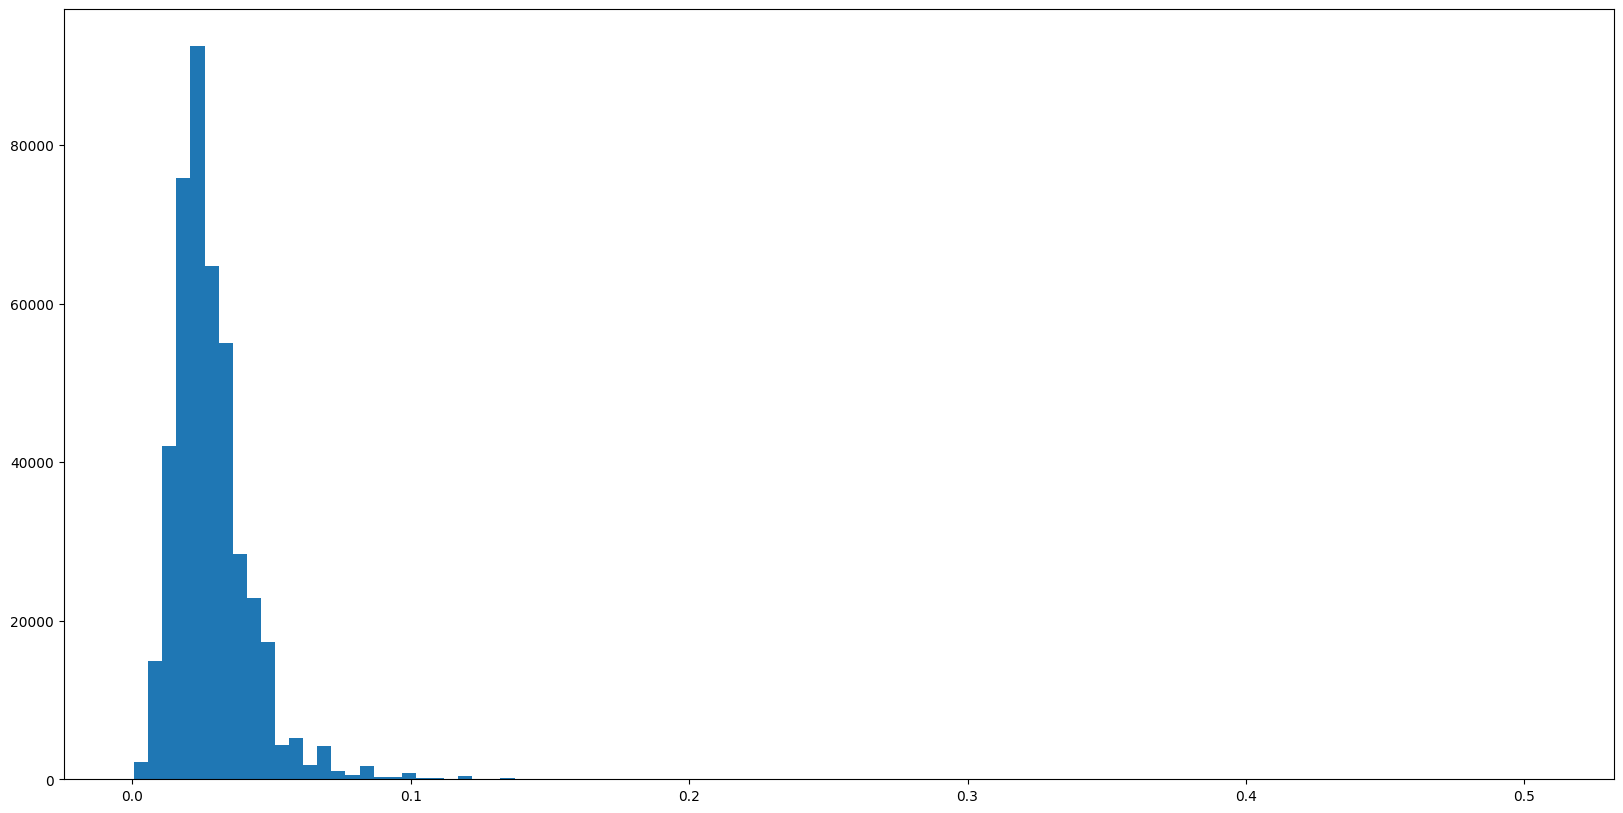

In [5]:
# create a plot to see the distribution of the mean_price_per_c column
plt.figure(figsize=(20, 10))
plt.hist(mean_price_per_c['mean_price_per_c'], bins=100)
plt.show()

In [6]:
c2index_group_name

,customer_id,highest_count_ign_per_c,count
717397,18442606110317830291,0,231
14356,371834049679164774,0,231
483365,12416564893706204993,0,196
670906,17234420386288341054,0,166
37771,979392728188584892,0,160
...,...,...,...
249873,6420757378897806626,0,1
249872,6420635653313041923,2,1
249868,6420532178711353262,2,1
528364,13570978177308658659,2,1


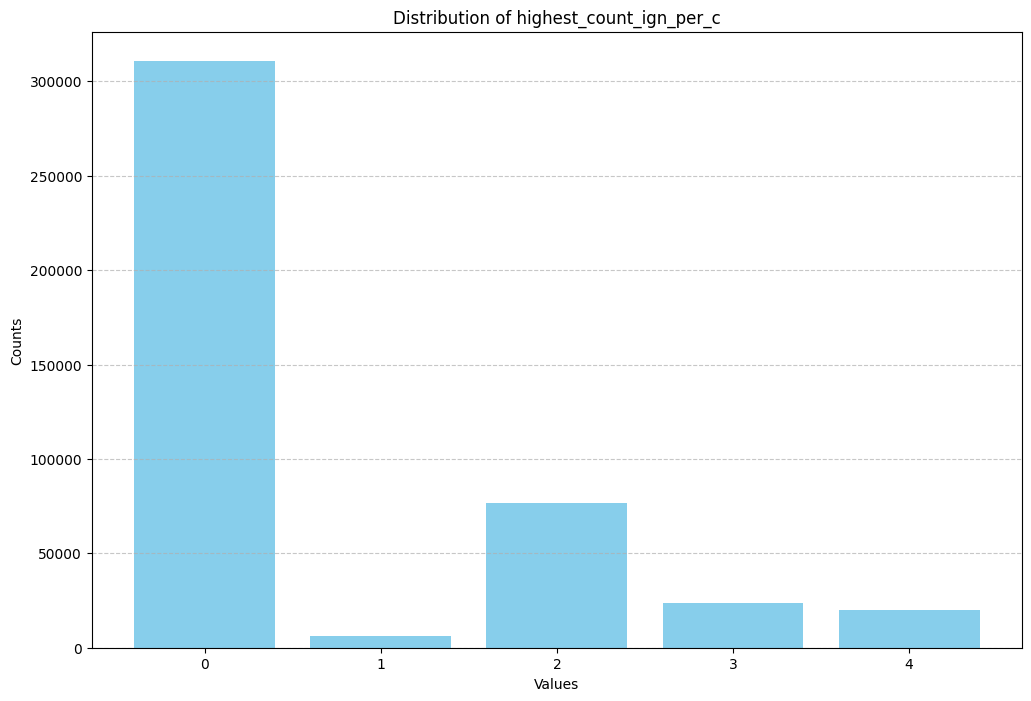

In [7]:
# Create plot to see the distribution of the highest_count_ign_per_c column
unique_values, counts = np.unique(c2index_group_name['highest_count_ign_per_c'], return_counts=True)

plt.figure(figsize=(12, 8))
ax = plt.subplot()

ax.bar(unique_values, counts, color='skyblue')

ax.set_title('Distribution of highest count ign per customer')
ax.set_xlabel('Values')
ax.set_ylabel('Counts')
ax.set_xticks(unique_values)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [8]:
mean_age_per_article

,article_id,mean_age_per_a
0,108775015,40
1,108775044,38
2,110065001,36
3,110065002,27
4,110065011,27
...,...,...
38326,952267001,34
38327,952938001,36
38328,953450001,31
38329,953763001,35


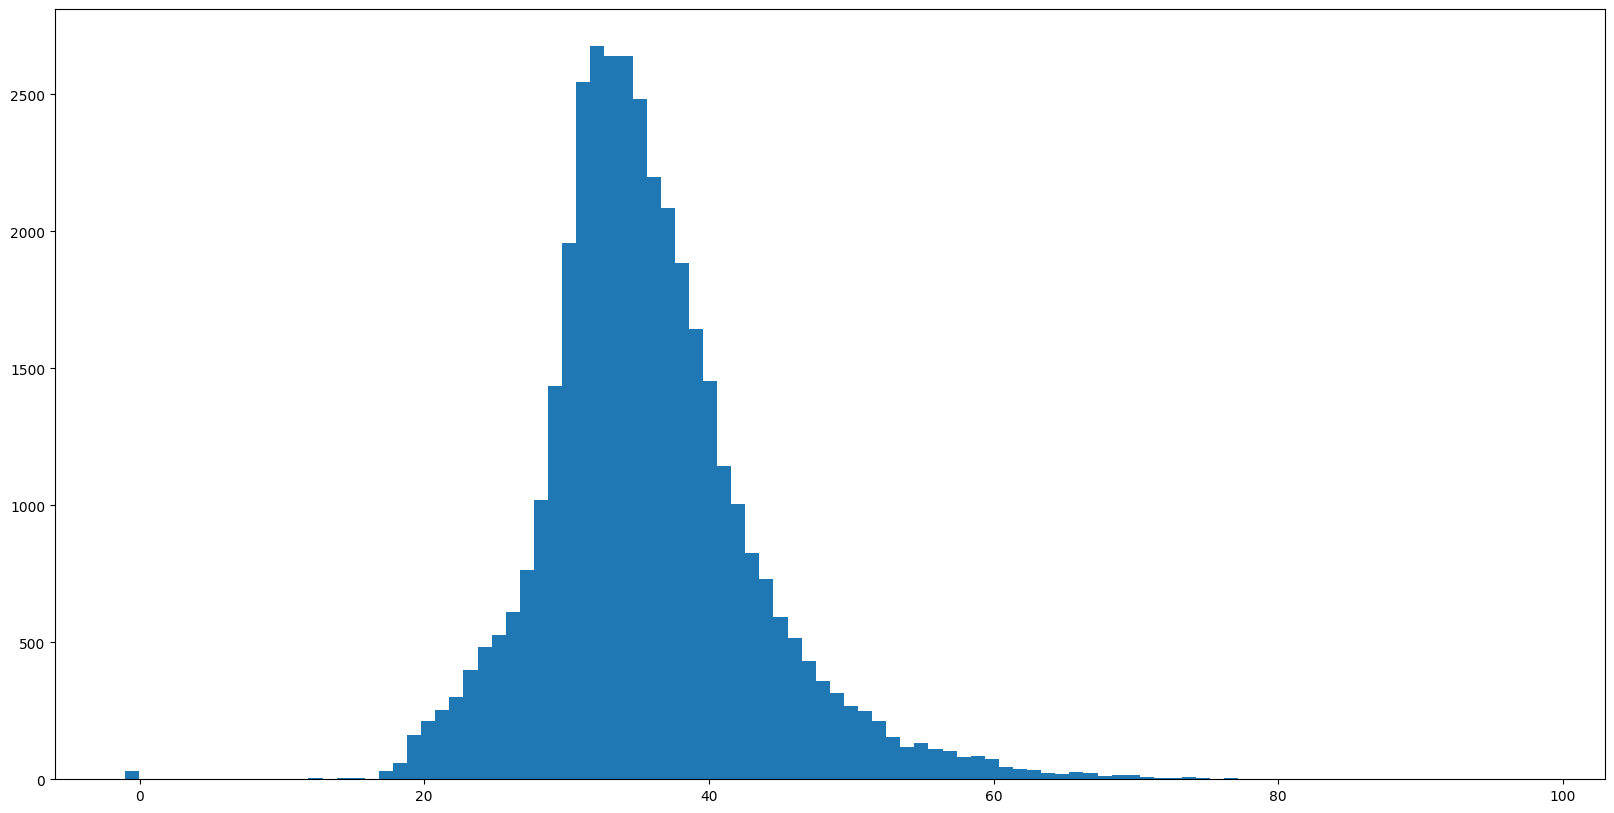

In [9]:
# Create plot to see the distribution of the mean age per article column
plt.figure(figsize=(20, 10))
plt.hist(mean_age_per_article['mean_age_per_a'], bins=100)
plt.show()

In [106]:
transactions_with_3feat

,t_dat,customer_id,article_id,price,sales_channel_id,week,age,highest_count_ign_per_c,mean_price_per_c,mean_age_per_a,index_group_name
0,2020-07-15,272412481300040,778064028,0.008458,1,95,48,0,0.030597,32,0
1,2020-07-15,272412481300040,816592008,0.016932,1,95,48,0,0.030597,37,2
2,2020-07-15,272412481300040,621381021,0.033881,1,95,48,0,0.030597,35,2
3,2020-07-15,272412481300040,817477003,0.025407,1,95,48,0,0.030597,33,0
4,2020-07-15,272412481300040,899088002,0.025407,1,95,48,0,0.030597,35,2
...,...,...,...,...,...,...,...,...,...,...,...
2762867,2020-09-22,18439937050817258297,891591003,0.084729,2,104,49,0,0.040379,41,0
2762868,2020-09-22,18439937050817258297,869706005,0.084729,2,104,49,0,0.040379,39,0
2762869,2020-09-22,18440902715633436014,918894002,0.016932,1,104,18,0,0.028232,30,0
2762870,2020-09-22,18440902715633436014,761269001,0.016932,1,104,18,0,0.028232,33,0


### Generate personalized candidates for each customer based on three features: age, index_group_name and mean purchase price of the customer.

In [107]:
# merge t with customers columns customer_id, age on customer_id for later use
t_merged = pd.merge(transactions_with_2feat, customers[['customer_id', 'age']], on='customer_id', how='left')
# Create a DataFrame with unique articles
unique_articles = transactions_with_3feat[['t_dat', 'sales_channel_id', 'article_id', 'price', 'index_group_name', 'week']].drop_duplicates()
# we only keep latest purchase of each article
unique_articles = unique_articles.sort_values('t_dat', ascending=False).drop_duplicates('article_id')

unique_customers = mean_price_per_c['customer_id'].unique()[:1000]
chunk_size = 1000  # Define the number of customers to process at once
chunks = [unique_customers[i:i + chunk_size] for i in range(0, len(unique_customers), chunk_size)]
topX_price=50 # top x candidates filtered by price columns
topX_age=25 # top x candidates filtered by age columns

top_candidates_3feat = get_candidates(chunks, unique_articles, t_merged,mean_age_per_article, topX_price, topX_age)

In [109]:
top_candidates_3feat

,t_dat,sales_channel_id,article_id,price,index_group_name,week,customer_id,highest_count_ign_per_c,mean_price_per_c,age,mean_age_per_a,price_rank,age_rank
0,2020-07-16,1,754852002,0.050831,0,95,28847241659200,0,0.046085,21,21,21.0,1.0
1,2020-07-21,1,747764002,0.047441,0,95,28847241659200,0,0.046085,21,22,2.0,2.0
2,2020-07-16,1,685944002,0.042356,0,95,28847241659200,0,0.046085,21,20,7.0,2.0
3,2020-07-19,1,746344001,0.033881,0,95,28847241659200,0,0.046085,21,20,36.0,2.0
4,2020-07-15,1,796042001,0.033881,0,95,28847241659200,0,0.046085,21,22,36.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,2020-09-22,2,761406005,0.022017,2,104,42984229297455520,2,0.021452,18,31,40.0,15.0
249996,2020-09-22,1,911034002,0.021678,2,104,42984229297455520,2,0.021452,18,32,12.0,22.0
249997,2020-09-22,1,670698020,0.021169,2,104,42984229297455520,2,0.021452,18,32,13.0,22.0
249998,2020-09-22,1,884405005,0.021169,2,104,42984229297455520,2,0.021452,18,32,13.0,22.0


In [110]:
top_candidates_3feat[top_candidates_3feat['customer_id'] == 272412481300040]

,t_dat,sales_channel_id,article_id,price,index_group_name,week,customer_id,highest_count_ign_per_c,mean_price_per_c,age,mean_age_per_a,price_rank,age_rank
1250,2020-07-20,1,578317003,0.027102,0,95,272412481300040,0,0.030597,48,48,26.0,1.0
1251,2020-07-18,1,690803001,0.033881,0,95,272412481300040,0,0.030597,48,47,11.0,2.0
1252,2020-07-17,1,559626001,0.025424,0,95,272412481300040,0,0.030597,48,47,45.0,2.0
1253,2020-07-21,2,594834018,0.030492,0,95,272412481300040,0,0.030597,48,46,1.0,4.0
1254,2020-07-15,2,757333004,0.030492,0,95,272412481300040,0,0.030597,48,50,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2020-09-22,2,557994003,0.030492,0,104,272412481300040,0,0.030597,48,34,4.0,18.0
1496,2020-09-22,1,843380004,0.030492,0,104,272412481300040,0,0.030597,48,34,4.0,18.0
1497,2020-09-22,1,883689001,0.030492,0,104,272412481300040,0,0.030597,48,34,4.0,18.0
1498,2020-09-22,2,874264001,0.030492,0,104,272412481300040,0,0.030597,48,34,4.0,18.0


In [111]:
top_candidates_3feat_prev_week = top_candidates_3feat.copy()
del top_candidates_3feat
top_candidates_3feat_prev_week.week += 1

In [112]:
top_candidates_3feat_prev_week

,t_dat,sales_channel_id,article_id,price,index_group_name,week,customer_id,highest_count_ign_per_c,mean_price_per_c,age,mean_age_per_a,price_rank,age_rank
0,2020-07-16,1,754852002,0.050831,0,96,28847241659200,0,0.046085,21,21,21.0,1.0
1,2020-07-21,1,747764002,0.047441,0,96,28847241659200,0,0.046085,21,22,2.0,2.0
2,2020-07-16,1,685944002,0.042356,0,96,28847241659200,0,0.046085,21,20,7.0,2.0
3,2020-07-19,1,746344001,0.033881,0,96,28847241659200,0,0.046085,21,20,36.0,2.0
4,2020-07-15,1,796042001,0.033881,0,96,28847241659200,0,0.046085,21,22,36.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,2020-09-22,2,761406005,0.022017,2,105,42984229297455520,2,0.021452,18,31,40.0,15.0
249996,2020-09-22,1,911034002,0.021678,2,105,42984229297455520,2,0.021452,18,32,12.0,22.0
249997,2020-09-22,1,670698020,0.021169,2,105,42984229297455520,2,0.021452,18,32,13.0,22.0
249998,2020-09-22,1,884405005,0.021169,2,105,42984229297455520,2,0.021452,18,32,13.0,22.0


In [113]:
recall_last_week = calculate_recall_per_customer_batch(validation, top_candidates_3feat_prev_week, unique_customers, topX_age)

Validation and candidates_last_week have the same number of unique customers
Recall Score on Candidates for Last Week: 0.0


In [114]:
unique_transactions_ = transactions.groupby(['week', 'customer_id']).head(1).drop(columns=['article_id', 'price']).copy()
candidates_ = top_candidates_3feat_prev_week.copy()
candidates_.drop(columns=['price_rank', 'age_rank', 'highest_count_ign_per_c', 'mean_price_per_c', 'index_group_name', 'mean_age_per_a', 'age'], inplace=True)

In [115]:
candidates_

,t_dat,sales_channel_id,article_id,price,week,customer_id
0,2020-07-16,1,754852002,0.050831,96,28847241659200
1,2020-07-21,1,747764002,0.047441,96,28847241659200
2,2020-07-16,1,685944002,0.042356,96,28847241659200
3,2020-07-19,1,746344001,0.033881,96,28847241659200
4,2020-07-15,1,796042001,0.033881,96,28847241659200
...,...,...,...,...,...,...
249995,2020-09-22,2,761406005,0.022017,105,42984229297455520
249996,2020-09-22,1,911034002,0.021678,105,42984229297455520
249997,2020-09-22,1,670698020,0.021169,105,42984229297455520
249998,2020-09-22,1,884405005,0.021169,105,42984229297455520


In [116]:
transactions['purchased'] = 1
data = pd.concat([transactions, candidates_last_purchase, candidates_])
data.purchased.fillna(0, inplace=True)
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

In [117]:
data

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95,1.0
29030504,2020-07-15,272412481300040,816592008,0.016932,1,95,1.0
29030505,2020-07-15,272412481300040,621381021,0.033881,1,95,1.0
29030506,2020-07-15,272412481300040,817477003,0.025407,1,95,1.0
29030507,2020-07-15,272412481300040,899088002,0.025407,1,95,1.0
...,...,...,...,...,...,...,...
249995,2020-09-22,42984229297455520,761406005,0.022017,2,105,0.0
249996,2020-09-22,42984229297455520,911034002,0.021678,1,105,0.0
249997,2020-09-22,42984229297455520,670698020,0.021169,1,105,0.0
249998,2020-09-22,42984229297455520,884405005,0.021169,1,105,0.0


In [118]:
data = pd.merge(
    data,
    top_candidates_3feat_prev_week[['week', 'article_id', 'price_rank', 'age_rank']],
    on=['week', 'article_id'],
    how='left'
)
data = data[data.week != data.week.min()]
data.price_rank.fillna(999, inplace=True)
data.age_rank.fillna(999, inplace=True)

In [119]:
data

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,price_rank,age_rank
261987,2020-07-22,200292573348128,880777001,0.025407,2,96,1.0,999.0,999.0
261988,2020-07-22,200292573348128,784332002,0.025407,2,96,1.0,999.0,999.0
261989,2020-07-22,200292573348128,827968001,0.016932,2,96,1.0,999.0,999.0
261990,2020-07-22,200292573348128,599580086,0.011847,2,96,1.0,999.0,999.0
261991,2020-07-22,248294615847351,720504008,0.031458,1,96,1.0,999.0,999.0
...,...,...,...,...,...,...,...,...,...
16993901,2020-09-22,42984229297455520,884405005,0.021169,1,105,0.0,13.0,22.0
16993902,2020-09-20,42984229297455520,850622002,0.021169,1,105,0.0,15.0,21.0
16993903,2020-09-20,42984229297455520,850622002,0.021169,1,105,0.0,15.0,21.0
16993904,2020-09-20,42984229297455520,850622002,0.021169,1,105,0.0,1.0,23.0


In [120]:
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [121]:
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

In [122]:
train

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,price_rank,age_rank,product_code,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2020-07-26,28847241659200,887770001,0.016932,1,96,1.0,999.0,999.0,887770,...,10,1010,6,3692,1,1,0,1,21,57896
1,2020-07-18,28847241659200,762846001,0.025407,1,96,0.0,999.0,999.0,762846,...,7,1010,6,492,1,1,0,1,21,57896
2,2020-07-18,28847241659200,829308001,0.033881,1,96,0.0,999.0,999.0,829308,...,21,1005,0,9082,1,1,0,1,21,57896
3,2020-07-16,28847241659200,754852002,0.050831,1,96,0.0,21.0,1.0,754852,...,45,1001,10,17015,1,1,0,1,21,57896
4,2020-07-16,28847241659200,754852002,0.050831,1,96,0.0,5.0,1.0,754852,...,45,1001,10,17015,1,1,0,1,21,57896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12340983,2020-09-20,18445641720816255142,923037003,0.033881,2,104,1.0,999.0,999.0,923037,...,31,1017,4,10043,1,1,0,1,31,147613
12340984,2020-09-21,18446737527580148316,547780001,0.023712,2,104,1.0,999.0,999.0,547780,...,27,1002,2,271,1,1,0,1,60,96323
12340985,2020-09-21,18446737527580148316,763988001,0.023712,2,104,1.0,999.0,999.0,763988,...,16,1002,2,1107,1,1,0,1,60,96323
12340986,2020-09-21,18446737527580148316,763988003,0.023712,2,104,1.0,999.0,999.0,763988,...,16,1002,2,1107,1,1,0,1,60,96323


In [123]:
test

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,price_rank,age_rank,product_code,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
12340988,2020-09-03,28847241659200,925246001,0.128797,2,105,0.0,999.0,999.0,925246,...,40,1007,9,27855,1,1,0,1,21,57896
12340989,2020-09-22,28847241659200,779068002,0.045746,2,105,0.0,7.0,1.0,779068,...,10,1003,3,15430,1,1,0,1,21,57896
12340996,2020-09-22,28847241659200,754323004,0.045746,2,105,0.0,7.0,2.0,754323,...,0,1003,3,4874,1,1,0,1,21,57896
12341003,2020-09-22,28847241659200,721481003,0.045746,2,105,0.0,7.0,3.0,721481,...,0,1010,6,11900,1,1,0,1,21,57896
12341010,2020-09-22,28847241659200,904225001,0.045746,1,105,0.0,7.0,3.0,904225,...,20,1020,7,26543,1,1,0,1,21,57896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16731910,2020-09-06,18446705133201055310,875784002,0.050831,2,105,0.0,999.0,999.0,875784,...,15,1003,3,11763,1,1,0,1,60,177867
16731911,2020-09-21,18446737527580148316,547780001,0.023712,2,105,0.0,13.0,15.0,547780,...,27,1002,2,271,1,1,0,1,60,96323
16731914,2020-09-21,18446737527580148316,763988001,0.023712,2,105,0.0,1.0,16.0,763988,...,16,1002,2,1107,1,1,0,1,60,96323
16731915,2020-09-21,18446737527580148316,763988003,0.023712,2,105,0.0,999.0,999.0,763988,...,16,1002,2,1107,1,1,0,1,60,96323


In [124]:
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values

In [125]:
train_baskets

array([2172, 2121, 3607, ...,    2,    7,    4], dtype=int64)

In [126]:
extra_columns = ['price_rank', 'age_rank']
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code']
columns_to_use.extend(extra_columns)

train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

In [127]:
test_X

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,price_rank,age_rank
12340988,925246001,262,1010016,9,4,5,1201,0,1,19,1007,1,1,0,1,21,57896,999.0,999.0
12340989,779068002,252,1010016,13,2,11,1610,0,1,6,1003,1,1,0,1,21,57896,7.0,1.0
12340996,754323004,252,1010010,14,4,11,1626,0,1,15,1003,1,1,0,1,21,57896,7.0,2.0
12341003,721481003,258,1010017,73,2,6,1522,0,1,15,1010,1,1,0,1,21,57896,7.0,3.0
12341010,904225001,87,1010016,9,4,5,3529,6,1,64,1020,1,1,0,1,21,57896,7.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16731910,875784002,252,1010016,9,4,12,1949,0,1,2,1003,1,1,0,1,60,177867,999.0,999.0
16731911,547780001,272,1010016,9,4,5,1643,1,2,51,1002,1,1,0,1,60,96323,13.0,15.0
16731914,763988001,272,1010016,9,4,5,5833,2,3,26,1002,1,1,0,1,60,96323,1.0,16.0
16731915,763988003,272,1010010,9,4,12,5833,2,3,26,1002,1,1,0,1,60,96323,999.0,999.0


# Model training and ranking

In [128]:
from lightgbm.sklearn import LGBMRanker
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)
ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())
    
test['preds'] = ranker.predict(test_X)

c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

best_last_week = \
    top_candidates_3feat_prev_week[top_candidates_3feat_prev_week.week == top_candidates_3feat_prev_week.week.max()]['article_id'].tolist()

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.889245
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.155714
[LightGBM] [Debug] init for col-wise cost 0.079666 seconds, init for row-wise cost 0.168006 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 12340988, number of used features: 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
price_rank 0.6835620043234258
article_id 0.11766371018323818
product_type_no 0.07645167159613835
garment_group_no 0.06177753506324362
department_no 0.04177899449274285
section_no 0.01131151231931095
graphical_appearance_no 0.004557535348505498
colour_group_code 0.002897036673

In [129]:
sub = pd.read_csv('../input/sample_submission.csv')
preds = []
for c_id in customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + best_last_week
    preds.append(pred[:12])

In [130]:
# Copied from NickWils
from tqdm import tqdm
# Creating validation set for metrics use case
positive_items_val = validation.groupby(['customer_id'])['article_id'].apply(list)
val_users = positive_items_val.keys()
val_items = []
for i, user in tqdm(enumerate(val_users)):
    val_items.append(positive_items_val[user])
    
print("Total users in validation:", len(val_users))
print("mAP12 Score on Validation set:", mapk(val_items, preds))
print("recall Score on Validation set:", recall12(val_items, preds))

68984it [00:00, 931431.45it/s]

Total users in validation: 68984
mAP12 Score on Validation set: 0.00020435931735109805
recall Score on Validation set: 0.0008370739349937931


In [131]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds
sub.to_csv(f'../basic_model_submission.csv.gz', index=False)

# Radek

In [132]:
transactions = transactions_copy.copy()
del transactions_copy

In [133]:
### Bestsellers candidates
mean_price = transactions.groupby(['week', 'article_id'])['price'].mean()
sales = transactions \
    .groupby('week')['article_id'].value_counts() \
    .groupby('week').rank(method='dense', ascending=False) \
    .groupby('week').head(12).rename('bestseller_rank').astype('int8')
bestsellers_previous_week = pd.merge(sales, mean_price, on=['week', 'article_id']).reset_index()
bestsellers_previous_week.week += 1

In [134]:
# bestsellers_previous_week.pipe(lambda df: df[df['week']==96])
bestsellers_previous_week

,week,article_id,bestseller_rank,price
0,1,685687003,1,0.016912
1,1,685687001,2,0.016904
2,1,685687004,3,0.016857
3,1,685687002,4,0.016922
4,1,562245001,5,0.023881
...,...,...,...,...
1255,105,915529003,8,0.033439
1256,105,915529005,9,0.033417
1257,105,448509014,10,0.041630
1258,105,762846027,11,0.025005


In [135]:
unique_transactions = transactions.groupby(['week', 'customer_id']).head(1).drop(columns=['article_id', 'price']).copy()
candidates_bestsellers = pd.merge(unique_transactions, bestsellers_previous_week, on='week',)
test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)
test_set_transactions.week = test_week

In [136]:
# candidates_bestsellers

In [137]:
# test_set_transactions
# unique_transactions

In [138]:
candidates_bestsellers_test_week = pd.merge(test_set_transactions, bestsellers_previous_week, on='week')
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
candidates_bestsellers.drop(columns='bestseller_rank', inplace=True)

In [139]:
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,article_id,price
0,2018-09-26,857913002275398,1,1,685687003,0.016912
1,2018-09-26,857913002275398,1,1,685687001,0.016904
2,2018-09-26,857913002275398,1,1,685687004,0.016857
3,2018-09-26,857913002275398,1,1,685687002,0.016922
4,2018-09-26,857913002275398,1,1,562245001,0.023881
...,...,...,...,...,...,...
16347367,2020-09-22,18417769707947924979,2,105,915529003,0.033439
16347368,2020-09-22,18417769707947924979,2,105,915529005,0.033417
16347369,2020-09-22,18417769707947924979,2,105,448509014,0.041630
16347370,2020-09-22,18417769707947924979,2,105,762846027,0.025005


# Combining transactions and candidates / negative examples

In [140]:
transactions['purchased'] = 1
data = pd.concat([transactions, candidates_last_purchase, candidates_bestsellers])
data.purchased.fillna(0, inplace=True)
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

In [141]:
data

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
25784,2018-09-20,1728846800780188,519773001,0.028458,2,0,1.0
25785,2018-09-20,1728846800780188,578472001,0.032525,2,0,1.0
5389,2018-09-20,2076973761519164,661795002,0.167797,2,0,1.0
5390,2018-09-20,2076973761519164,684080003,0.101678,2,0,1.0
47429,2018-09-20,2918879973994241,662980001,0.033881,1,0,1.0
...,...,...,...,...,...,...,...
16347367,2020-09-22,18417769707947924979,915529003,0.033439,2,105,0.0
16347368,2020-09-22,18417769707947924979,915529005,0.033417,2,105,0.0
16347369,2020-09-22,18417769707947924979,448509014,0.041630,2,105,0.0
16347370,2020-09-22,18417769707947924979,762846027,0.025005,2,105,0.0


### Add bestseller information

In [142]:
data = pd.merge(
    data,
    bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
    on=['week', 'article_id'],
    how='left'
)
data = data[data.week != data.week.min()]
data.bestseller_rank.fillna(999, inplace=True)
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [143]:
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

In [144]:
test

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,product_code,prod_name,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
124800519,2020-04-10,4245900472157,924243001,0.041535,2,105,0.0,1.0,924243,19190,...,0,1003,3,13007,-1,-1,0,0,21,64922
124800520,2020-04-10,4245900472157,924243002,0.041877,2,105,0.0,2.0,924243,19190,...,0,1003,3,13007,-1,-1,0,0,21,64922
124800521,2020-04-10,4245900472157,918522001,0.041435,2,105,0.0,3.0,918522,26372,...,0,1003,3,28633,-1,-1,0,0,21,64922
124800522,2020-04-10,4245900472157,923758001,0.033462,2,105,0.0,4.0,923758,19359,...,0,1010,6,27869,-1,-1,0,0,21,64922
124800523,2020-04-10,4245900472157,866731001,0.025015,2,105,0.0,5.0,866731,3609,...,21,1005,0,3130,-1,-1,0,0,21,64922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142509656,2018-09-29,18446737527580148316,915529003,0.033439,1,105,0.0,8.0,915529,7046,...,0,1003,3,10909,1,1,0,1,60,96323
142509657,2018-09-29,18446737527580148316,915529005,0.033417,1,105,0.0,9.0,915529,7046,...,0,1003,3,10909,1,1,0,1,60,96323
142509658,2018-09-29,18446737527580148316,448509014,0.041630,1,105,0.0,10.0,448509,259,...,1,1009,5,255,1,1,0,1,60,96323
142509659,2018-09-29,18446737527580148316,762846027,0.025005,1,105,0.0,11.0,762846,472,...,7,1010,6,492,1,1,0,1,60,96323


In [145]:
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values

In [146]:
train_baskets

array([18, 13, 17, ..., 14, 19, 16], dtype=int64)

In [147]:
extra_columns = []
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']
columns_to_use.extend(extra_columns)

In [148]:
train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

In [149]:
test_X

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,bestseller_rank
124800519,924243001,252,1010016,13,1,1,1626,0,1,15,1003,-1,-1,0,0,21,64922,1.0
124800520,924243002,252,1010016,9,4,5,1626,0,1,15,1003,-1,-1,0,0,21,64922,2.0
124800521,918522001,252,1010016,11,3,9,1626,0,1,15,1003,-1,-1,0,0,21,64922,3.0
124800522,923758001,-1,1010016,10,3,9,1522,0,1,15,1010,-1,-1,0,0,21,64922,4.0
124800523,866731001,273,1010016,9,4,5,8310,9,26,5,1005,-1,-1,0,0,21,64922,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142509656,915529003,252,1010016,9,4,5,1626,0,1,15,1003,1,1,0,1,60,96323,8.0
142509657,915529005,252,1010016,13,1,1,1626,0,1,15,1003,1,1,0,1,60,96323,9.0
142509658,448509014,272,1010016,72,3,2,1747,1,2,53,1009,1,1,0,1,60,96323,10.0
142509659,762846027,259,1010016,13,1,1,1515,0,1,11,1010,1,1,0,1,60,96323,11.0


# Model training

In [150]:
from lightgbm.sklearn import LGBMRanker
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)
ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

MemoryError: Unable to allocate 16.7 GiB for an array with shape (124800519, 18) and data type float64

In [ ]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

# Calculate predictions

In [ ]:
test['preds'] = ranker.predict(test_X)

c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

bestsellers_last_week = \
    bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()

# Create submission

In [ ]:
sub = pd.read_csv('../input/sample_submission.csv')
preds = []
for c_id in customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_last_week
    preds.append(pred[:12])

In [ ]:
from tqdm import tqdm
positive_items_val = validation.groupby(['customer_id'])['article_id'].apply(list)
# creating validation set for metrics use case
val_users = positive_items_val.keys()
val_items = []
for i, user in tqdm(enumerate(val_users)):
    val_items.append(positive_items_val[user])

print("Total users in validation:", len(val_users))
print("mAP12 Score on Validation set:", mapk(val_items, preds))
print("recall Score on Validation set:", recall12(val_items, preds))

In [ ]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
# sub.prediction = preds
# sub_name = 'basic_model_submission'
# sub.to_csv(f'{sub_name}.csv.gz', index=False)